In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 100
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                verbose=True, val_ratio=0.2, random_state=random_state)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.03528, val loss: 0.03443
Main effects training epoch: 2, train loss: 0.01994, val loss: 0.02006
Main effects training epoch: 3, train loss: 0.01963, val loss: 0.01961
Main effects training epoch: 4, train loss: 0.01954, val loss: 0.01957
Main effects training epoch: 5, train loss: 0.01946, val loss: 0.01951
Main effects training epoch: 6, train loss: 0.01938, val loss: 0.01943
Main effects training epoch: 7, train loss: 0.01928, val loss: 0.01934
Main effects training epoch: 8, train loss: 0.01916, val loss: 0.01924
Main effects training epoch: 9, train loss: 0.01903, val loss: 0.01913
Main effects training epoch: 10, train loss: 0.01888, val loss: 0.01899
Main effects training epoch: 11, train loss: 0.01868, val loss: 0.01881
Main effects training epoch: 12, train loss: 0.01842, val loss: 0.01861
Main effects training e

Main effects training epoch: 114, train loss: 0.01125, val loss: 0.01165
Main effects training epoch: 115, train loss: 0.01120, val loss: 0.01161
Main effects training epoch: 116, train loss: 0.01132, val loss: 0.01179
Main effects training epoch: 117, train loss: 0.01119, val loss: 0.01165
Main effects training epoch: 118, train loss: 0.01117, val loss: 0.01161
Main effects training epoch: 119, train loss: 0.01119, val loss: 0.01164
Main effects training epoch: 120, train loss: 0.01120, val loss: 0.01168
Main effects training epoch: 121, train loss: 0.01117, val loss: 0.01160
Main effects training epoch: 122, train loss: 0.01116, val loss: 0.01158
Main effects training epoch: 123, train loss: 0.01115, val loss: 0.01160
Main effects training epoch: 124, train loss: 0.01113, val loss: 0.01158
Main effects training epoch: 125, train loss: 0.01112, val loss: 0.01159
Main effects training epoch: 126, train loss: 0.01114, val loss: 0.01157
Main effects training epoch: 127, train loss: 0.011

Main effects training epoch: 227, train loss: 0.01057, val loss: 0.01111
Main effects training epoch: 228, train loss: 0.01055, val loss: 0.01112
Main effects training epoch: 229, train loss: 0.01058, val loss: 0.01115
Main effects training epoch: 230, train loss: 0.01055, val loss: 0.01110
Main effects training epoch: 231, train loss: 0.01059, val loss: 0.01113
Main effects training epoch: 232, train loss: 0.01057, val loss: 0.01115
Main effects training epoch: 233, train loss: 0.01057, val loss: 0.01111
Main effects training epoch: 234, train loss: 0.01075, val loss: 0.01127
Main effects training epoch: 235, train loss: 0.01064, val loss: 0.01122
Main effects training epoch: 236, train loss: 0.01056, val loss: 0.01112
Main effects training epoch: 237, train loss: 0.01054, val loss: 0.01110
Main effects training epoch: 238, train loss: 0.01066, val loss: 0.01124
Main effects training epoch: 239, train loss: 0.01055, val loss: 0.01111
Main effects training epoch: 240, train loss: 0.010

Interaction training epoch: 30, train loss: 0.00554, val loss: 0.00554
Interaction training epoch: 31, train loss: 0.00551, val loss: 0.00550
Interaction training epoch: 32, train loss: 0.00548, val loss: 0.00548
Interaction training epoch: 33, train loss: 0.00547, val loss: 0.00547
Interaction training epoch: 34, train loss: 0.00543, val loss: 0.00546
Interaction training epoch: 35, train loss: 0.00542, val loss: 0.00545
Interaction training epoch: 36, train loss: 0.00546, val loss: 0.00544
Interaction training epoch: 37, train loss: 0.00538, val loss: 0.00539
Interaction training epoch: 38, train loss: 0.00537, val loss: 0.00542
Interaction training epoch: 39, train loss: 0.00536, val loss: 0.00541
Interaction training epoch: 40, train loss: 0.00536, val loss: 0.00537
Interaction training epoch: 41, train loss: 0.00530, val loss: 0.00532
Interaction training epoch: 42, train loss: 0.00528, val loss: 0.00530
Interaction training epoch: 43, train loss: 0.00529, val loss: 0.00531
Intera

Interaction training epoch: 145, train loss: 0.00309, val loss: 0.00315
Interaction training epoch: 146, train loss: 0.00291, val loss: 0.00302
Interaction training epoch: 147, train loss: 0.00290, val loss: 0.00305
Interaction training epoch: 148, train loss: 0.00287, val loss: 0.00296
Interaction training epoch: 149, train loss: 0.00289, val loss: 0.00296
Interaction training epoch: 150, train loss: 0.00286, val loss: 0.00297
Interaction training epoch: 151, train loss: 0.00288, val loss: 0.00294
Interaction training epoch: 152, train loss: 0.00284, val loss: 0.00293
Interaction training epoch: 153, train loss: 0.00278, val loss: 0.00291
Interaction training epoch: 154, train loss: 0.00281, val loss: 0.00294
Interaction training epoch: 155, train loss: 0.00273, val loss: 0.00285
Interaction training epoch: 156, train loss: 0.00272, val loss: 0.00282
Interaction training epoch: 157, train loss: 0.00281, val loss: 0.00298
Interaction training epoch: 158, train loss: 0.00271, val loss: 

Interaction training epoch: 259, train loss: 0.00218, val loss: 0.00236
Interaction training epoch: 260, train loss: 0.00210, val loss: 0.00225
Interaction training epoch: 261, train loss: 0.00220, val loss: 0.00239
Interaction training epoch: 262, train loss: 0.00211, val loss: 0.00227
Interaction training epoch: 263, train loss: 0.00213, val loss: 0.00232
Interaction training epoch: 264, train loss: 0.00207, val loss: 0.00224
Interaction training epoch: 265, train loss: 0.00207, val loss: 0.00226
Interaction training epoch: 266, train loss: 0.00208, val loss: 0.00227
Interaction training epoch: 267, train loss: 0.00207, val loss: 0.00226
Interaction training epoch: 268, train loss: 0.00213, val loss: 0.00231
Interaction training epoch: 269, train loss: 0.00208, val loss: 0.00228
Interaction training epoch: 270, train loss: 0.00207, val loss: 0.00225
Interaction training epoch: 271, train loss: 0.00207, val loss: 0.00226
Interaction training epoch: 272, train loss: 0.00213, val loss: 

Fine tuning epoch: 14, train loss: 0.00215, val loss: 0.00220
Fine tuning epoch: 15, train loss: 0.00208, val loss: 0.00214
Fine tuning epoch: 16, train loss: 0.00211, val loss: 0.00218
Fine tuning epoch: 17, train loss: 0.00212, val loss: 0.00218
Fine tuning epoch: 18, train loss: 0.00211, val loss: 0.00217
Fine tuning epoch: 19, train loss: 0.00211, val loss: 0.00218
Fine tuning epoch: 20, train loss: 0.00208, val loss: 0.00216
Fine tuning epoch: 21, train loss: 0.00206, val loss: 0.00214
Fine tuning epoch: 22, train loss: 0.00210, val loss: 0.00219
Fine tuning epoch: 23, train loss: 0.00212, val loss: 0.00218
Fine tuning epoch: 24, train loss: 0.00206, val loss: 0.00214
Fine tuning epoch: 25, train loss: 0.00214, val loss: 0.00223
Fine tuning epoch: 26, train loss: 0.00209, val loss: 0.00218
Fine tuning epoch: 27, train loss: 0.00210, val loss: 0.00218
Fine tuning epoch: 28, train loss: 0.00211, val loss: 0.00218
Fine tuning epoch: 29, train loss: 0.00209, val loss: 0.00216
Fine tun

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

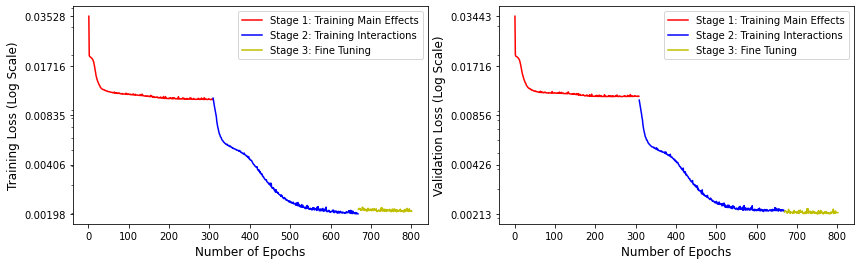

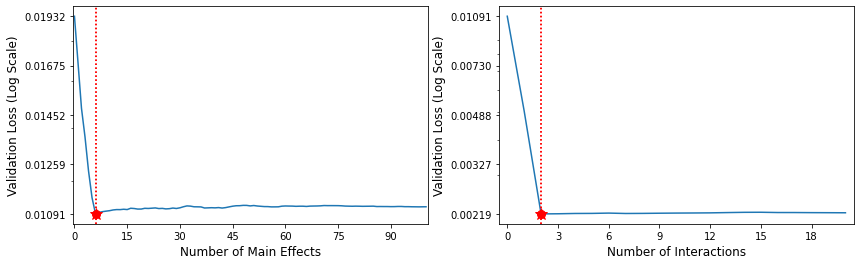

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

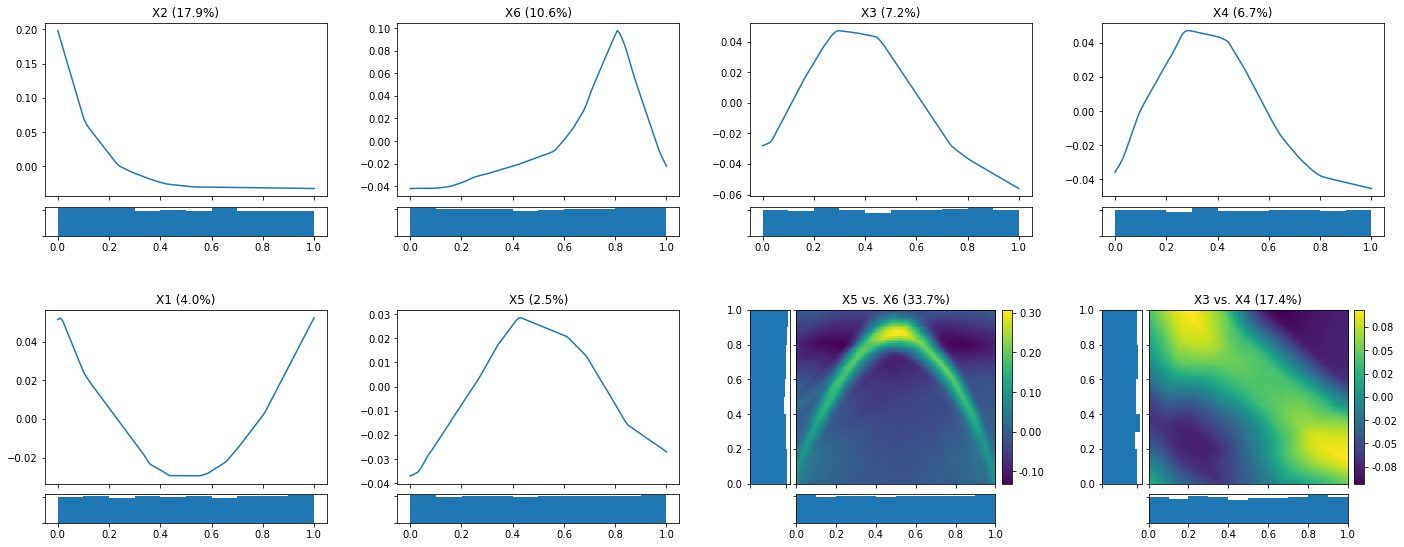

In [6]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')

Feature Importance

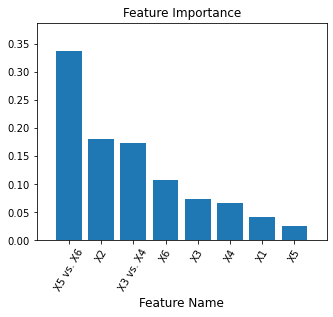

In [7]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [8]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

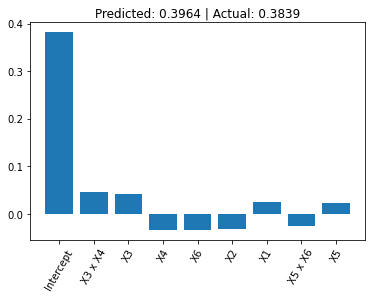

In [9]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

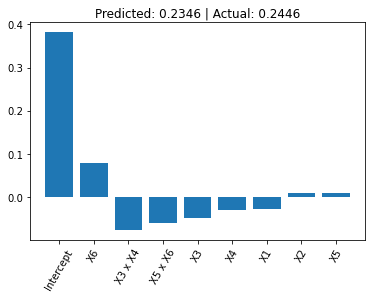

In [10]:
local_visualize(data_dict_local[1], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [11]:
model.save(folder="./", name="model_saved")

In [12]:
## The reloaded model should not be refit again
modelnew = GAMINet(meta_info={})
modelnew.load(folder="./", name="model_saved")